In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [10]:
#load the mnist dataset
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [11]:
#create train and test loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [4]:
#create a cnn architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)
        #add softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x

NameError: name 'nn' is not defined

In [1]:
#create the model
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = nn.CrossEntropyLoss()

NameError: name 'CNN' is not defined

In [2]:
def train_model(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):

    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y) in enumerate(train_dataloader):
            
            #send data to gpu
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in train_dataloader:
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [3]:
#train the teacher model
traing_accs, test_accs = train_model(teacher_model, train_loader, test_loader, teacher_optimizer, teacher_loss, 5)

NameError: name 'teacher_model' is not defined

In [44]:
import torch
from torch.utils.data import Dataset

class TeacherOutputDataset(Dataset):
    def __init__(self, images, teacher_probs, labels):
        self.images = images
        self.teacher_probs = teacher_probs
        self.labels = labels

    def __getitem__(self, index):
        image = self.images[index]
        teacher_prob = self.teacher_probs[index]
        label = self.labels[index]
        return image, teacher_prob, label

    def __len__(self):
        return len(self.images)


In [1]:
#Create a new dataset with the teacher model predictions

def create_teach_model_dataset(teacher_model) -> torch.utils.data.TensorDataset:
    teacher_model.eval()
    teacher_input = []
    teacher_predicted_probailities = []
    true_labels = []
    with torch.no_grad():
        for X, y in train_loader:
            X = X.to(device)
            y.to(device)
            y_pred = teacher_model(X)
            teacher_input.append(X)
            teacher_predicted_probailities.append(y_pred)
            true_labels.append(y)
            
    teacher_input = torch.cat(teacher_input)
    teacher_predicted_probailities = torch.cat(teacher_predicted_probailities)
    true_labels = torch.cat(true_labels)
    
    #create the custom dataset
    teacher_dataset = TeacherOutputDataset(teacher_input, teacher_predicted_probailities, true_labels)
    
    #create the loader
    teacher_loader = torch.utils.data.DataLoader(teacher_dataset, batch_size=100, shuffle=True)
    
    return teacher_dataset, teacher_loader


NameError: name 'torch' is not defined

In [54]:
teacher_dataset, teacher_loader = create_teach_model_dataset(teacher_model)

tensor([0.0000e+00, 4.7802e-27, 7.9001e-26, 1.0000e+00, 9.8996e-32, 1.9711e-24,
        3.7010e-35, 4.7187e-30, 2.0564e-23, 3.2087e-35], device='mps:0')
tensor(3)


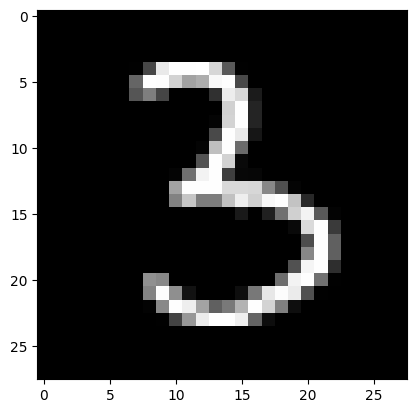

In [62]:
#plot the first image with the teacher model output and true label
image_example = teacher_dataset[8]

plt.imshow(image_example[0].cpu().squeeze().numpy(), cmap='gray')
print(image_example[1])
print(image_example[2])
plt.show()

In [78]:
#create student model
student_model = CNN()
student_model.to(device)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
student_loss = nn.CrossEntropyLoss()

In [86]:
def train_model_student(model, train_dataloader, test_dataloader, optimizer, loss_fn, num_epochs, CUDA=False, print_accs=True):

    traing_accs = []
    test_accs = []

    for epoch in range(1, num_epochs+1):
        
        model.train()
        # Write training loop here
        for i, (X, y, l) in enumerate(train_dataloader):
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()

        # Write evaluation loop(s) here
        
        # Calculate training accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y, l in train_dataloader:
                
                X = X.to(device)
                y = y.to(device)
                
                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                _, true_classes = torch.max(y, dim=1)
                
                total += y.size(0)
                correct += (predicted == true_classes).sum().item()
                
        #print(f"Epoch {epoch}, Training Accuracy: {correct / total}")
        traing_accs.append(correct / total)
        
        # Calculate test accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_dataloader:
                
                X = X.to(device)
                y = y.to(device)

                y_pred = model(X)
                
                _, predicted = torch.max(y_pred.data, 1)
                
                total += y.size(0)
                correct += (predicted == y).sum().item()
                
        #print(f"Epoch {epoch}, Accuracy: {correct / total}")
        if print_accs:
            print(f"Epoch {epoch}, Training Accuracy: {traing_accs[-1]}, Validation Accuracy: {correct / total}")
        
        test_accs.append(correct / total)
        # Do not forget to use model.train() and model.eval() before training and evaluation loops respectively.
    return traing_accs, test_accs
    

In [87]:
#create random tensor
random_tensor = torch.rand(10, 2)
print(random_tensor)
a, b = torch.max(random_tensor, 1)

print(a,b)

tensor([[7.8148e-01, 6.3241e-01],
        [6.2220e-02, 2.8373e-01],
        [1.8811e-02, 9.5838e-04],
        [9.6615e-01, 7.3277e-01],
        [5.7466e-01, 1.8098e-01],
        [9.2220e-01, 5.0182e-01],
        [7.3610e-01, 6.5570e-01],
        [3.0053e-02, 9.0833e-01],
        [9.9513e-01, 8.1330e-01],
        [9.1412e-01, 6.7514e-01]])
tensor([0.7815, 0.2837, 0.0188, 0.9662, 0.5747, 0.9222, 0.7361, 0.9083, 0.9951,
        0.9141]) tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0])


In [88]:
#train the student model
traing_accs, test_accs = train_model_student(student_model, teacher_loader, test_loader, student_optimizer, student_loss, 5)

Epoch 1, Training Accuracy: 0.9869166666666667, Validation Accuracy: 0.9829
Epoch 2, Training Accuracy: 0.9893333333333333, Validation Accuracy: 0.984
Epoch 3, Training Accuracy: 0.9911166666666666, Validation Accuracy: 0.9866
Epoch 4, Training Accuracy: 0.9927333333333334, Validation Accuracy: 0.9873
Epoch 5, Training Accuracy: 0.9924, Validation Accuracy: 0.9865


In [89]:
from fgsm import create_fgsm_adversarial_example
from fgsm import can_import

In [90]:
can_import()

FGSM file can import!


In [232]:
def create_fgsm_adversarial_example(model, criterion, X, y, epsilon):
    X.requires_grad = True
    model.zero_grad()
    
    X = X.to(device)
    X.retain_grad()
    y = y.to(device)
    
    output = model(X)
    model_prediction_unperturbed = output.argmax(dim=1)
    prediction_confidence = F.softmax(output, dim=1).max()
    loss = criterion(output, y)
    loss.backward()
    
    x_grad = X.grad
    x_adv = X + epsilon * x_grad.sign()
    return model_prediction_unperturbed, prediction_confidence, x_adv

In [ ]:
#get one image
ex = teacher_dataset[8]
X = ex[0]
print(X)

#create adversarial example
model_prediction_unperturbed, prediction_confidence, x_adv = create_fgsm_adversarial_example(teacher_model, teacher_loss, X.unsqueeze(0), ex[2].unsqueeze(0), 0.6)

#plot perturbed image
plt.imshow(x_adv.detach().cpu().squeeze().numpy(), cmap='gray')

In [181]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [253]:
def evaluate_model_on_adversarial_input(model, model_criterion, test_dataloader, epsilon=0.1):
    
    #set batch size of 1
    test_dataloader = torch.utils.data.DataLoader(test_dataloader.dataset, batch_size=1, shuffle=False)
    
    raw_image_prections = []
    adv_image_predictions = []
    true_labels = []
    
    for X, y in test_dataloader:
        
        X = X.to(device)
        y = y.to(device)
        
        true_labels.append(y)
        
        #get the predictions on the raw image
        raw_image_prediction = model(X)
        _, raw_image_predicted = torch.max(raw_image_prediction.data, 1)
        raw_image_prections.append(raw_image_predicted)
        
        #create adversarial example
        _, _, x_adv = create_fgsm_adversarial_example(model, model_criterion, X, y, epsilon)
        
        #get the predictions on the adversarial image
        adv_image_prediction = model(x_adv)
        _, adv_image_predicted = torch.max(adv_image_prediction.data, 1)
        adv_image_predictions.append(adv_image_predicted)
            
    #concatenate the predictions
    raw_image_prections = torch.cat(raw_image_prections)
    adv_image_predictions = torch.cat(adv_image_predictions)
    true_labels = torch.cat(true_labels)
                
    return raw_image_prections, adv_image_predictions, true_labels

In [254]:
#evaluate the student model on adversarial examples

raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(teacher_model, teacher_loss, test_loader, epsilon=0.1)

In [ ]:
#calculate the accuracy on raw and adversarial examples

#convert the predictions to numpy
raw_image_prections = raw_image_prections.cpu().numpy()
adv_image_predictions = adv_image_predictions.cpu().numpy()
true_labels = true_labels.cpu().numpy()

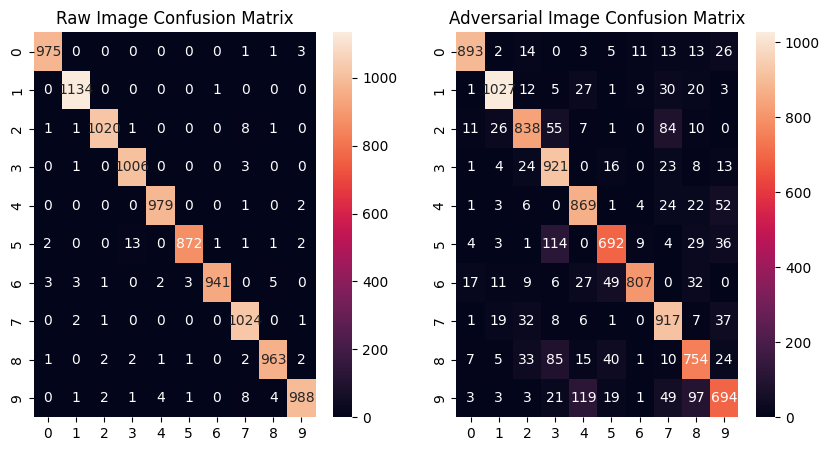

In [263]:


#calculate confusion matrices
from sklearn.metrics import confusion_matrix
raw_image_confusion_matrix = confusion_matrix(true_labels, raw_image_prections)
adv_image_confusion_matrix = confusion_matrix(true_labels, adv_image_predictions)

#plot the confusion matrices
import seaborn as sns


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(raw_image_confusion_matrix, annot=True, fmt='g')
plt.title('Raw Image Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(adv_image_confusion_matrix, annot=True, fmt='g')
plt.title('Adversarial Image Confusion Matrix')
plt.show()




In [264]:
#evaluate accuracy for a range of epsilon values

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []

for eps in epsilons:
    raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(teacher_model, teacher_loss, test_loader, epsilon=eps)
    
    #calculate the accuracy on raw and adversarial examples
    raw_image_accuracy = (raw_image_prections == true_labels).sum().item() / len(true_labels)
    adv_image_accuracy = (adv_image_predictions == true_labels).sum().item() / len(true_labels)
    
    accuracies.append((raw_image_accuracy, adv_image_accuracy))



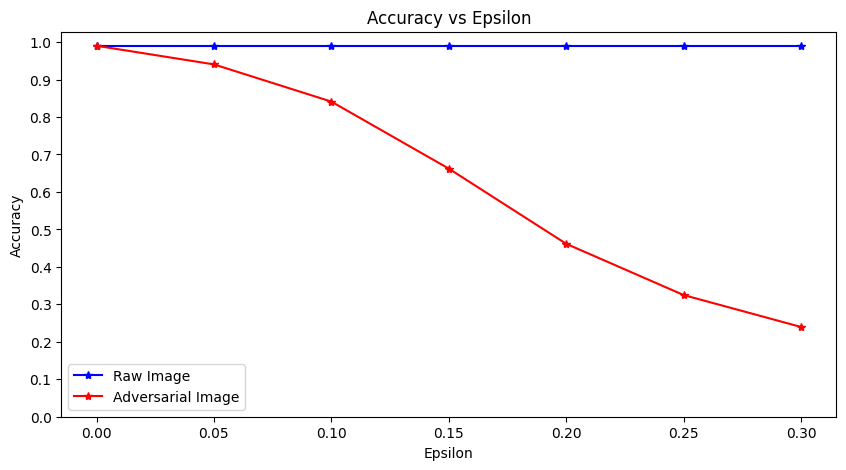

In [265]:
#plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilons, [a[0] for a in accuracies], 'b*-')
plt.plot(epsilons, [a[1] for a in accuracies], 'r*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Teacher Model Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend(['Raw Image', 'Adversarial Image'])
plt.show()

In [266]:
#evaluate the student model on adversarial examples
raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(student_model, student_loss, test_loader, epsilon=0.1)

In [268]:
#calculate the accuracy on raw and adversarial examples

#convert the predictions to numpy
raw_image_prections = raw_image_prections.cpu().numpy()
adv_image_predictions = adv_image_predictions.cpu().numpy()
true_labels = true_labels.cpu().numpy()

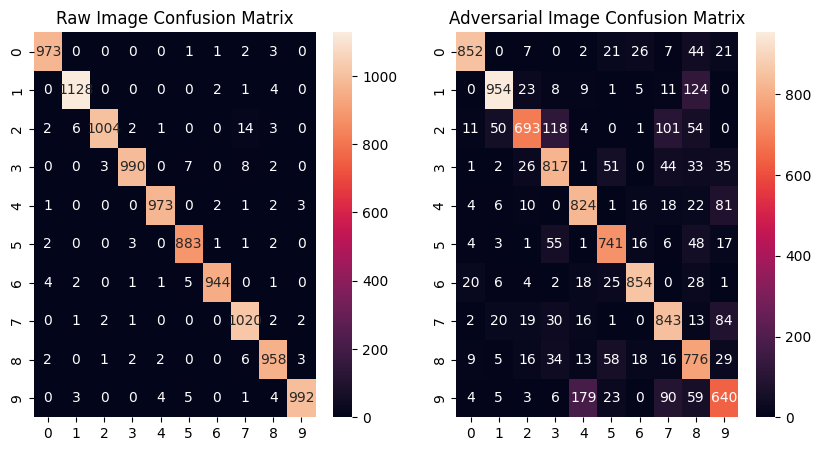

In [269]:
#calculate confusion matrices for sutdent model
raw_image_confusion_matrix = confusion_matrix(true_labels, raw_image_prections)
adv_image_confusion_matrix = confusion_matrix(true_labels, adv_image_predictions)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(raw_image_confusion_matrix, annot=True, fmt='g')
plt.title('Raw Image Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(adv_image_confusion_matrix, annot=True, fmt='g')
plt.title('Adversarial Image Confusion Matrix')
plt.show()

In [270]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
accuracies = []

for eps in epsilons:
    raw_image_prections, adv_image_predictions, true_labels = evaluate_model_on_adversarial_input(student_model, student_loss, test_loader, epsilon=eps)
    
    #calculate the accuracy on raw and adversarial examples
    raw_image_accuracy = (raw_image_prections == true_labels).sum().item() / len(true_labels)
    adv_image_accuracy = (adv_image_predictions == true_labels).sum().item() / len(true_labels)
    
    accuracies.append((raw_image_accuracy, adv_image_accuracy))
    

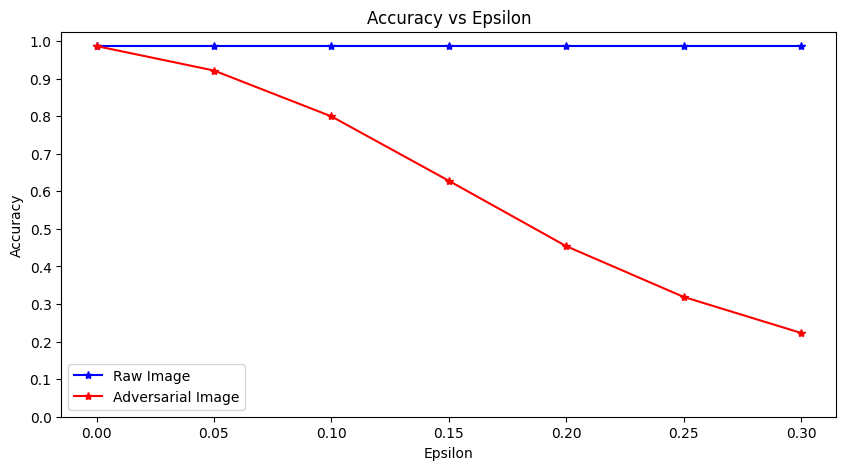

In [271]:
#plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(epsilons, [a[0] for a in accuracies], 'b*-')
plt.plot(epsilons, [a[1] for a in accuracies], 'r*-')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend(['Raw Image', 'Adversarial Image'])
plt.show()

tensor([7.2631e-15, 5.3707e-15, 4.2146e-13, 1.5749e-08, 1.7427e-11, 2.7287e-13,
        1.2211e-24, 1.3413e-08, 4.4697e-10, 1.0000e+00], device='mps:0')
tensor(9)


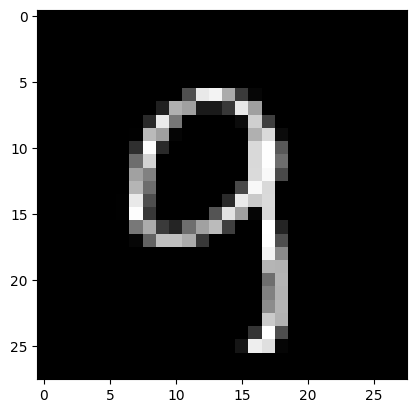

In [240]:
#print first image from training set
image_example = teacher_dataset[0]

plt.imshow(image_example[0].cpu().squeeze().numpy(), cmap='gray')
print(image_example[1])
print(image_example[2])
plt.show()


Text(0.5, 1.0, 'True Label: 5')

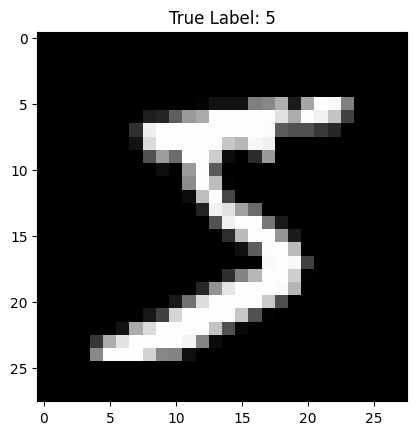

In [211]:
#plot the first image from the student dataset

im = train_loader.dataset[0][0].squeeze().numpy()
label = train_loader.dataset[0][1]
plt.imshow(im, cmap='gray')
plt.title(f'True Label: {label}')

torch.Size([1, 28, 28])
tensor([0])
model gradient saved
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.4549, 0.4902, 0.6706, 1.0000, 1.0000, 0.5882,


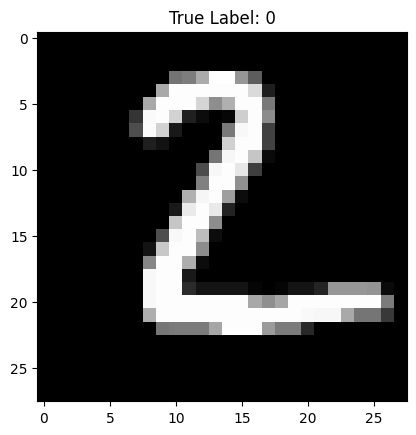

In [212]:
#create an adversarial example
input_label = train_loader.dataset[1][1]

#convert y to tensor
y_tensor = torch.tensor([input_label])

print(train_loader.dataset[1][0].shape)
print(y_tensor)

model_prediction_unperturbed, prediction_confidence, x_adv = create_fgsm_adversarial_example(student_model, student_loss, test_loader.dataset[1][0], y_tensor, epsilon=0.3)


#plot the orginal image
plt.imshow(test_loader.dataset[1][0].squeeze().numpy(), cmap='gray')
plt.title(f'True Label: {input_label}')
plt.show()

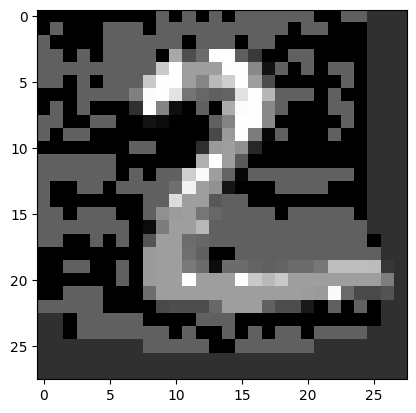

In [213]:
#plot the adversarial image
plt.imshow(x_adv.cpu().squeeze().detach().numpy(), cmap='gray')

In [ ]:
print(x_adv.shape)

In [133]:
#make a prediction on the orginal image
teacher_output = teacher_model(x_adv)
#apply softmax
teacher_output = F.softmax(teacher_output, dim=1)
#convert to numpy array
teacher_output = teacher_output.detach().numpy()
#plot student output
plt.bar(range(10), teacher_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Teacher Model predicted probalities")
plt.show()

student_output = student_model(x_adv)
# apply softmax
student_output = F.softmax(student_output, dim=1)
# convert to numpy array
student_output = student_output.detach().numpy()

# plot student output
plt.bar(range(10), student_output[0])
plt.xlabel('Digit')
plt.ylabel('Probability')
plt.title("Student Model predicted probalities")
plt.show()


TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

### We can see here that the teacher model incorrectly predicts class 2 for the image whereas the student model is able to correctly classify the perturbed image. This is a clear indication that the student model is more robust to adversarial attacks than the teacher model.